# NRPy 2-torial: Solving the Scalar Wave Equation with `NumPy`

## Authors: Zach Etienne, Patrick Nelson, Terrence Pierre Jacques, Thiago Assumpção, Leo Werneck, Brandon Clark

(*Note on Authors*: Zach wrote the NRPy infrastructure, as well as this notebook and its Python code; Patrick wrote the first version of the NRPy-based Einstein Toolkit thorns for solving the scalar wave equation in 2018; Terrence rewrote these thorns to the latest NRPy standards in 2020, along the lines of the [`BaikalETK` thorns](Tutorial-BaikalETK.ipynb); Thiago extended the scalar wave initial data infrastructure and contributed fixes to the original NRPy scalar wave notebooks; Leo created the boundary condition animation below; and Brandon established NRPy notebook formatting standards.)

This notebook was first written as a tutorial to introduce NRPy during the 2020 Einstein Toolkit Workshop.

## This notebook constructs and validates a code that solves the scalar wave equation $\partial_t^2 u = c^2 \nabla^2 u$ using `NumPy`, to both review the basic components of a numerical PDE solver and motivate the use of NRPy.

This notebook was written to explicitly outline the basic algorithms for numerically solving [hyperbolic PDEs](https://en.wikipedia.org/wiki/Hyperbolic_partial_differential_equation), **including Einstein's equations of general relativity in e.g., the BSSN formalism**.

While the codes here are written by hand, the objective of the notebook is to motivate the use of NRPy, which can be used to generate much of this code either *automatically* or from validated templates, greatly reducing the possibility of human error. 

**Notebook Status:** <font color='green'><b>Validated</b></font>

**Validation Notes:** The code developed in this tutorial notebook has been confirmed to converge to the exact solution at the expected rate, as documented below.

# Table of Contents

1. [Step 0](#prereqs): Prerequisites & Additional Reading
1. [Step 1](#intro): Introduction: The scalar wave equation
    1. [Step 1.a](#problem_statement): Mathematical problem statement
    1. [Step 1.b](#solution): Chosen solution to the scalar wave equation
    1. [Step 1.c](#initial_condition): Initial condition
1. [Step 2](#mol): The Method of Lines (MoL)
1. [Step 3](#basicalg): `NumPy` Implementation: Basic Algorithm
    1. [Step 3.a](#numgrid_freeparams): Set up the numerical grid and free parameters
    1. [Step 3.b](#numpy_id): Set up the initial data
    1. [Step 3.c](#numpy_gfs): Allocate memory for the gridfunctions storing $u$ and $v$, and define the indexing macro function
    1. [Step 3.d](#numpy_rhss): Define the right-hand sides of the PDEs
    1. [Step 3.e](#numpy_bcs): Boundary Conditions
    1. [Step 3.f](#numpy_mol): The Method of Lines
    1. [Step 3.g](#numpy_driver): The main driver function
1. [Step 4](#too_slow): Argh, the code is SLOW! Why use NRPy instead?
1. [Step 5](#error_analysis): Error analysis & code validation: Confirming numerical errors converge to zero at the expected rate
1. [Step 6](#student_exercises): Exercises for students
1. [Step 7](#latex_pdf_output): Output this notebook to $\LaTeX$-formatted PDF file

# Step 0: Prerequisites & Additional Reading
###\[Back to [top](#toc)\]

This tutorial assumes basic familiarity with computer programming, undergraduate mathematics, and computational physics or numerical analysis.

For additional reading, please consult the following links:

* [Online Resources for Numerical Analysis & Basic Mathematics](https://etienneresearch.com/MATH521-f2018/notes__additional_reading.html)
* [Numerical Recipes in C](http://www.numerical.recipes/) Feel free to use the *free* "obsolete" (but not really!) versions. Note that Numerical Recipes were written by numerical relativists!

# Step 1: Introduction: The scalar wave equation
### \[Back to [top](#toc)\]

We will write a Python code (based in [NumPy](https://numpy.org/)) to numerically solve the scalar wave equation

$$\partial_t^2 u(t,x,y,z) = c^2 \nabla^2 u(t,x,y,z),$$

given initial conditions $u(t=t_0,x,y,z)$.

<a id='problem_statement'></a>

## Step 1.a: Mathematical problem statement
### \[Back to [top](#toc)\]
$$\label{problem_statement}$$

We will numerically solve the scalar wave equation as an [initial value problem](https://en.wikipedia.org/wiki/Initial_value_problem) in Cartesian coordinates:
$$\partial_t^2 u = c^2 \nabla^2 u,$$
where $u$ (the amplitude of the wave) is a function of time and space: $u = u(t,x,y,...)$ (spatial dimension as-yet unspecified) and $c$ is the wave speed, subject to some initial condition

$$u(0,x,y,...) = f(x,y,...)$$

and suitable spatial boundary conditions (we'll stick with simple extrapolation boundary conditions at first).

As described in the next section, we will find it quite useful to define
$$v(t,x,y,...) = \partial_t u(t,x,y,...).$$

In this way, the second-order PDE is reduced to a set of two coupled first-order PDEs in time

\begin{align}
\partial_t u &= v \\
\partial_t v &= c^2 \nabla^2 u.
\end{align}

We will use NRPy to generate efficient C codes capable of generating both initial data $u(0,x,y,...) = f(x,y,...)$; $v(0,x,y,...)=g(x,y,...)$, as well as finite-difference expressions for the right-hand sides of the above expressions. These expressions are needed within the *Method of Lines* to "integrate" the solution forward in time.

## Step 1.b: Chosen solution to the scalar wave equation
### \[Back to [top](#toc)\]

Here we will implement the spherical Gaussian solution to the scalar wave equation, which consists of ingoing and outgoing wavefronts:
\begin{align}
u(r,t) &= u_{\rm out}(r,t) + u_{\rm in}(r,t) + u_{\rm offset},\ \ \text{where}\\
u_{\rm out}(r,t) &=\frac{r-ct}{r} \exp\left[\frac{-(r-ct)^2}{2 \sigma^2}\right] \\
u_{\rm in}(r,t) &=\frac{r+ct}{r} \exp\left[\frac{-(r+ct)^2}{2 \sigma^2}\right] \\
\end{align}
where $c$ is the wavespeed, $u_{\rm offset}$ is a freely specifiable constant offset, and $\sigma$ is the width of the Gaussian (i.e., the "standard deviation"). Next, we'll demonstrate using SymPy (a computer algebra system written in Python, on which NRPy depends) that the above indeed is a solution to the scalar wave equation.

In Cartesian coordinates we have
$$
\partial_t^2 u(t,x,y,z) = c^2 \nabla^2 u(t,x,y,z),
$$
and we know that
$$
r = \sqrt{x^2+y^2+z^2},
$$
which we implement below using [SymPy](https://www.sympy.org/), the Python computer algebra package that NRPy uses.

In [1]:
import sympy as sp  # SymPy: The Python computer algebra package upon which NRPy depends

# Declare independent variables t,x,y,z as (real-valued) SymPy symbols
t,x,y,z = sp.symbols('t x y z', real=True)

# Declare the parameters c, sigma, and u_offset as (real-valued) SymPy symbols as well.
#   In NRPy we'd declare these as NRPy *parameters*
c, sigma, u_offset = sp.symbols('c sigma u_offset', real=True)

# Then define r:
r = sp.sqrt(x**2 + y**2 + z**2)

# Next set up the solution u(t,x,y,z):
# First the outgoing wave
u_out = (r - c*t)/r * sp.exp(-(r - c*t)**2 / (2*sigma**2))
# ... and then the ingoing wave
u_in  = (r + c*t)/r * sp.exp(-(r + c*t)**2 / (2*sigma**2))

u_exact = u_out + u_in + u_offset

# ... and then v, which is the time derivative of u:
v_exact = sp.diff(u_exact, t)

Here is a visualization of this solution over time $u_{\rm exact}(t)$ in the $x-z$ plane, generated using [matplotlib](https://matplotlib.org/):

In [2]:
from IPython.display import IFrame
# Youtube
IFrame('https://www.youtube.com/embed/TJOo2JIW53g?rel=0&amp;controls=0&amp;showinfo=0',560,315)

Now let's confirm the solution solves the PDE:
$$
\partial_t^2 u(t,x,y,z) = c^2 \nabla^2 u(t,x,y,z),
$$
by confirming that
$$
\partial_t^2 u(t,x,y,z) - c^2 \nabla^2 u(t,x,y,z) = 0,
$$
using SymPy to compute the second derivatives of $u$ symbolically. To make it easier for SymPy to simplify the resulting expression, we will split up the above equation into:

$$
\partial_t^2 (u_{\rm in} + u_{\rm out} + u_{\rm offset}) - c^2 \nabla^2 (u_{\rm in} + u_{\rm out} + u_{\rm offset}) = 0,
$$
and confirm that
\begin{align}
\partial_t^2 u_{\rm in} - c^2 \nabla^2 u_{\rm in} &= 0 \\
\partial_t^2 u_{\rm out} - c^2 \nabla^2 u_{\rm out} &= 0 \\
\partial_t^2 u_{\rm offset} - c^2 \nabla^2 u_{\rm offset} &= 0,
\end{align}
which must be the case since the scalar wave equation is a [linear PDE](https://en.wikipedia.org/wiki/Partial_differential_equation), in which each of the waves (ingoing, outgoing, and constant) must satisfy the wave equation separately:

In [3]:
# Finally confirm that the solution indeed solves the PDE,
#   by subtracting the left-hand-side from the right-hand-side
#   of the equation and simplifying; we should get zero
scalarwave_lhs_in  = sp.diff(u_in,  t, 2)
scalarwave_lhs_out = sp.diff(u_out, t, 2)
scalarwave_lhs_ost = sp.diff(u_offset, t, 2)
scalarwave_rhs_in  = c**2 * (sp.diff(u_in,  x, 2) + sp.diff(u_in,  y, 2) + sp.diff(u_in,  z, 2))
scalarwave_rhs_out = c**2 * (sp.diff(u_out, x, 2) + sp.diff(u_out, y, 2) + sp.diff(u_out, z, 2))
scalarwave_rhs_ost = c**2 * (sp.diff(u_offset, x, 2) + sp.diff(u_offset, y, 2) + sp.diff(u_offset, z, 2))

scalarwave_lhs_minus_rhs_in  = sp.simplify(scalarwave_lhs_in  - scalarwave_rhs_in)
scalarwave_lhs_minus_rhs_out = sp.simplify(scalarwave_lhs_out - scalarwave_rhs_out)
scalarwave_lhs_minus_rhs_ost = sp.simplify(scalarwave_lhs_ost - scalarwave_rhs_ost)

print("(rhs - lhs) = %s" % (scalarwave_lhs_minus_rhs_in+scalarwave_lhs_minus_rhs_out+scalarwave_lhs_minus_rhs_ost))

(rhs - lhs) = 0


## Step 1.c: Initial Condition
### \[Back to [top](#toc)\]

We will choose the above solution at $t=0$, $u(t=0,x,y,z)$, as our initial data and adopt the Method of Lines (described next) to advance the solution forward in time (i.e., solve the initial value problem).

# Step 2: The Method of Lines (MoL)
### \[Back to [top](#toc)\]

Once we have set our initial conditions (usually referred to as our "initial data"), we "evolve it forward in time", using the [Method of Lines](https://reference.wolfram.com/language/tutorial/NDSolveMethodOfLines.html). In short, the Method of Lines enables us to handle
1. the **spatial derivatives** of an initial value problem PDE using **standard finite difference approaches**, and
2. the **temporal derivatives** of an initial value problem PDE using **standard strategies for solving ordinary differential equations (ODEs)**, so long as the initial value problem PDE can be written in the form
$$\partial_t \vec{f} = \mathbf{M}\ \vec{f},$$
where $\mathbf{M}$ is an $N\times N$ matrix filled with differential operators that act on the $N$-element column vector $\vec{f}$. $\mathbf{M}$ may not contain $t$ or time derivatives explicitly; only *spatial* partial derivatives are allowed to appear inside $\mathbf{M}$. The scalar wave equation as written in the [previous module](Tutorial-ScalarWave.ipynb)
\begin{equation}
\partial_t 
\begin{bmatrix}
u \\
v 
\end{bmatrix}=
\begin{bmatrix}
0 & 1 \\
c^2 \nabla^2  & 0 
\end{bmatrix}
\begin{bmatrix}
u \\
v 
\end{bmatrix}
\end{equation}
satisfies this requirement. 

Thus we can treat the spatial derivatives $\nabla^2 u$ of the scalar wave equation  using **standard finite-difference approaches**, and the temporal derivatives $\partial_t u$ and $\partial_t v$ using **standard approaches for solving ODEs**. 

Here we will apply the highly robust [explicit Runge-Kutta fourth-order scheme](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) (RK4), used widely for numerically solving ODEs, to "march" (integrate) the solution vector $\vec{f}$ forward in time from its initial value ("initial data").

Here's how MoL works.

The RK4 method is usually presented for solving the ODE
$$
y'(t) = f(y,t)
$$
as follows. Given initial data $y(t_0)=y_0$, one can construct the solution at any later time via the algorithm:
\begin{align}
k_1 &= f(y_n, t_n), \\
k_2 &= f(y_n + \frac{1}{2}\Delta tk_1, t_n + \frac{\Delta t}{2}), \\
k_3 &= f(y_n + \frac{1}{2}\Delta tk_2, t_n + \frac{\Delta t}{2}), \\
k_4 &= f(y_n + \Delta tk_3, t_n + \Delta t), \\
y_{n+1} &= y_n + \frac{1}{6}\Delta t(k_1 + 2k_2 + 2k_3 + k_4) + \mathcal{O}\big((\Delta t)^5\big).
\end{align}

Our PDE involves two variables $u$ and $v$, and the algorithm generalizes in exactly the same manner as it would if we were solving a system of coupled ODEs with two variables. Further, our PDE does not contain explicit time dependence, which simplifies the algorithm a bit:
\begin{align}
k_{1,u} &= f_u(u_n,v_n) = f_u(v_n) = v_n, \\
k_{1,v} &= f_v(u_n,v_n) = f_v(u_n) = c^2\nabla^2 u_n, \\
k_{2,u} &= f_u\left(v_n + \frac{1}{2}\Delta tk_{1,v}\right) = v_n + \frac{1}{2}\Delta tk_{1,v}\\
k_{2,v} &= f_v\left(u_n + \frac{1}{2}\Delta tk_{1,u}\right) = c^2\nabla^2 \left(u_n + \frac{1}{2}\Delta tk_{1,u}\right), \\
k_{3,u} &= f_u\left(v_n + \frac{1}{2}\Delta tk_{2,v}\right) = v_n + \frac{1}{2}\Delta tk_{2,v}\\
k_{3,v} &= f_v\left(u_n + \frac{1}{2}\Delta tk_{2,u}\right) = c^2\nabla^2 \left(u_n + \frac{1}{2}\Delta tk_{2,u}\right), \\
k_{4,u} &= f_u(v_n + \Delta tk_{3,v}) = v_n + \Delta tk_{3,v}\\
k_{4,v} &= f_v(u_n + \Delta tk_{3,u}) = c^2\nabla^2 \left(u_n + \Delta tk_{3,u}\right), \\
u_{n+1} &= u_n + \frac{1}{6}\Delta t(k_{1,u} + 2k_{2,u} + 2k_{3,u} + k_{4,u}) + \mathcal{O}\big((\Delta t)^5\big)\\
v_{n+1} &= v_n + \frac{1}{6}\Delta t(k_{1,v} + 2k_{2,v} + 2k_{3,v} + k_{4,v}) + \mathcal{O}\big((\Delta t)^5\big).
\end{align}

Thus, given initial data $u_0$ and $v_0$, we can use the above algorithm to advance the solution forward in time by one timestep, to $u_1$ and $v_1$. Recall the $\nabla^2 u$ terms in the above expressions are computed using finite-difference derivatives. Since finite-difference derivatives require neighboring points to be evaluated, we only evaluate the $k_i$'s in the interior of the grid; at each step, we apply boundary conditions to fill in the outermost neighboring points (called ghost zones).

# Step 3: `NumPy` Implementation: Basic Algorithm
### \[Back to [top](#toc)\]

We will store the numerical solution $u$ and its time derivative $v$, *at a given instant in time* on a three-dimensional numerical grid. Since these variables are defined at each point on the numerical grid, we call them **gridfunctions**.

We refer to the right-hand side of the equation $\partial_t \vec{f} = \mathbf{M}\ \vec{f}$ as the RHS. In this case, we refer to the $\mathbf{M}\ \vec{f}$ as the **scalar wave RHSs**.

Armed with these definitions, the basic algorithm for solving the scalar wave equation [initial value problem](https://en.wikipedia.org/wiki/Initial_value_problem), based on the Method of Lines (see section above) is outlined below.

1. Set up the numerical grid and free parameters
1. Allocate memory for gridfunctions, including temporary storage needed for the RK4 time integration.
1. Set gridfunction values to initial data.
1. Evolve the system forward in time using RK4 time integration. At each RK4 substep, do the following:
    1. Evaluate scalar wave RHS expressions.
    1. Apply boundary conditions.

In the following sections, we will implement this algorithm to solve the scalar wave equation in 3D *by hand* using [NumPy](https://numpy.org/), and to motivate the use of NRPy.

## Step 3.a: `NumPy` Implementation: Set up the numerical grid and free parameters
### \[Back to [top](#toc)\]

We will solve the scalar wave equation on a uniform Cartesian grid with `Nx` by `Ny` by `Nz` coordinate points in the $x$, $y$, and $z$ directions respectively. Since the grid is uniform, we can describe the $x$ coordinate of any gridpoint with a single integer $i$, and the same holds true for $y$ and $z$, for which we will use integers $j$ and $k$. Thus we will label each gridpoint $(x_i,y_j,z_k)$.

Let's choose a "cell-centered" grid, which will store the solution at points
$$
x_i \in \{..., -\frac{3}{2} \Delta x, -\frac{1}{2} \Delta x, +\frac{1}{2} \Delta x, +\frac{3}{2} \Delta x  ...\};
$$
and we will allow for two additional ghost zones on the outer boundary to account for the fourth-order finite differencing we will implement to numerically compute $\nabla^2 u$. Thus the expression for computing $x_i$ will be

$$
x_i = x_{\rm min} + \left( (i-\text{NGHOSTS}) + \frac{1}{2} \right) \Delta x,
$$
where $\Delta x$ is the spacing between gridpoints, and $x_{\rm min}$ denotes the minimum grid value in $x$. We will solve this equation on a cube centered on the origin with the `domain_size=10`, where $x_{\rm min}=$ `-domain_size`, $y_{\rm min}=$ `-domain_size`, $z_{\rm min}=$ `-domain_size`, $x_{\rm max}=$ `+domain_size`, and so forth. We'll also choose `Nx=Ny=Nz`, so that

$$
\Delta x = \Delta y = \Delta z = \frac{x_{\rm max}-x_{\rm min}}{\text{Nx}}.
$$

In [4]:
import numpy as np  # NumPy: A numerical methods Python module
domain_size = 1.0

Nx = Ny = Nz = 24
# We add two ghostzones for the outer boundary; needed because our
#   finite-differencing stencils are two gridpoints wide.
NGHOSTS = 2

xx = np.zeros(Nx+2*NGHOSTS)
yy = np.zeros(Ny+2*NGHOSTS)
zz = np.zeros(Nz+2*NGHOSTS)

xmin = ymin = zmin = -domain_size
xmax = ymax = zmax = +domain_size

dx = (xmax - xmin) / Nx
for i in range(Nx + 2*NGHOSTS):
    xx[i] = xmin + (i - NGHOSTS + 0.5) * dx
dy = (ymax - ymin) / Ny
for j in range(Ny + 2*NGHOSTS):
    yy[j] = ymin + (j - NGHOSTS + 0.5) * dy
dz = (zmax - zmin) / Nz
for k in range(Nz + 2*NGHOSTS):
    zz[k] = zmin + (k - NGHOSTS + 0.5) * dz

Next we set the free parameters for the scalar wave solution:

In [5]:
# Set free parameters
freeparam_c     = 1.0  # wave speed
freeparam_sigma = 3.0  # width of Gaussian
freeparam_u_offset=1.0  # offset of solution

Then we set the timestep, which is governed by the [CFL condition](https://en.wikipedia.org/wiki/Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition), and the final time `t_final`, relative to the chosen start time $t_0$ (usually $t_0=0$), so that the points closest to origin aren't affected by the approximate boundary condition:

In [6]:
dt = 0.5*min(dx,min(dy,dz))/freeparam_c
t_final = domain_size*0.5

## Step 3.b: `NumPy` Implementation: Set up the initial data
### \[Back to [top](#toc)\]

Now we'll set up `exact_solution_all_points(time, u, v)`, which numerically evaluates the solution for $u$ and $v$ at all gridpoints at a given numerical time `time`.

Recall the exact solution is given by
\begin{align}
u(r,t) &= u_{\rm out}(r,t) + u_{\rm in}(r,t) + 1,\ \ \text{where}\\
u_{\rm out}(r,t) &=\frac{r-ct}{r} \exp\left[\frac{-(r-ct)^2}{2 \sigma^2}\right] \\
u_{\rm in}(r,t) &=\frac{r+ct}{r} \exp\left[\frac{-(r+ct)^2}{2 \sigma^2}\right].
\end{align}

*Exercise for students: Prove that at $t=0$, $v=\partial_t u \equiv 0$.*

The problem is, SymPy expressions need to be converted to NumPy expressions; otherwise using functions like `sp.N()` will be *incredibly slow*. So we attempt to fix this by some simple string manipulations, some for $v$ were done by hand using the below Python function.

In [7]:
def opt_string_replace(input):
    return input.replace("sqrt","np.sqrt").replace("exp","np.exp").\
      replace("x**2","x_i*x_i").replace("y**2","y_j*y_j").replace("z**2","z_k*z_k").\
      replace("c*t", "freeparam_c*time").replace("sigma", "freeparam_sigma")

print(opt_string_replace(str(u_exact)))
print(opt_string_replace(str(v_exact)))

u_offset + (-freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))*np.exp(-(-freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))**2/(2*freeparam_sigma**2))/np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k) + (freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))*np.exp(-(freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))**2/(2*freeparam_sigma**2))/np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k)
c*np.exp(-(freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))**2/(2*freeparam_sigma**2))/np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k) - c*np.exp(-(-freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))**2/(2*freeparam_sigma**2))/np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k) + c*(-freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))**2*np.exp(-(-freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))**2/(2*freeparam_sigma**2))/(freeparam_sigma**2*np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k)) - c*(freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))**2*np.exp(-(freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k

In [8]:
def exact_solution_single_pt_u(time, x_i,y_j,z_k):
                # Kludge: The following expressions were pasted from above:
                return (-freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))*np.exp(-(-freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))**2/(2*freeparam_sigma**2))/np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k) + (freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))*np.exp(-(freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))**2/(2*freeparam_sigma**2))/np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k) + freeparam_u_offset
def exact_solution_single_pt_v(time, x_i,y_j,z_k):
                # Kludge: The following expressions were pasted from above, and edited slightly by hand
                #         to convert the symbol c to the numerical value for c, freeparam_c
                return freeparam_c*np.exp(-(freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))**2/(2*freeparam_sigma**2))/np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k) - freeparam_c*np.exp(-(-freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))**2/(2*freeparam_sigma**2))/np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k) + freeparam_c*(-freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))**2*np.exp(-(-freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))**2/(2*freeparam_sigma**2))/(freeparam_sigma**2*np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k)) - freeparam_c*(freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))**2*np.exp(-(freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))**2/(2*freeparam_sigma**2))/(freeparam_sigma**2*np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))

def exact_solution_all_points(time, u, v):
    for k in range(0, Nz+2*NGHOSTS):
        z_k = zz[k]
        for j in range(0, Ny+2*NGHOSTS):
            y_j = yy[j]
            for i in range(0, Nx+2*NGHOSTS):
                x_i = xx[i]
                u[IDX3D(i,j,k)] = exact_solution_single_pt_u(time, x_i,y_j,z_k)
                v[IDX3D(i,j,k)] = exact_solution_single_pt_v(time, x_i,y_j,z_k)

To store the solution $u$ and $v$ at all gridpoints on our numerical grid cube requires 

`2*Nx*Ny*Nz*double`

bytes of memory, where `double` is the amount of memory storage (in bytes) needed to store one [double-precision number](https://en.wikipedia.org/wiki/Double-precision_floating-point_format) (this is 8, by the way).

## Step 3.c: `NumPy` Implementation: Allocate memory for the gridfunctions storing $u$ and $v$, and define the indexing macro function
### \[Back to [top](#toc)\]

In [9]:
# Allocate memory for gridfunctions. We need ghostzones
u = np.zeros((Nx+2*NGHOSTS) * (Ny+2*NGHOSTS) * (Nz+2*NGHOSTS))
v = np.zeros((Nx+2*NGHOSTS) * (Ny+2*NGHOSTS) * (Nz+2*NGHOSTS))

As is done in the Einstein Toolkit and native NRPy codes, instead of declaring multi-dimensional arrays (e.g., a 3D array), we will instead declare $u$ and $v$ as *one-dimensional* arrays `u[ijk]` and `v[ijk]`, each with `(Nx+2*NGHOSTS)*(Ny+2*NGHOSTS)*(Nz+2*NGHOSTS)` gridpoints. To access data an arbitrary point $(x_i,y_j,z_k)$, we need only call a simple function to find the correct index `ijk` given the grid indices `i`, `j`, and `k`, which label the point $(x_i,y_j,z_k)$:

$$
\verb|
(i,j,k) = i + (Nx+2*NGHOSTS)*j + (Nx+2*NGHOSTS)*(Ny+2*NGHOSTS)*k = i + (Nx+2*NGHOSTS)*(j + (Ny+2*NGHOSTS)*k)|
$$

In [10]:
# Define the indexing macro function
def IDX3D(i,j,k):
    return i + (Nx+2*NGHOSTS)*(j + (Ny+2*NGHOSTS)*k)

## Step 3.d: `NumPy` Implementation: Define the right-hand sides of the PDEs
### \[Back to [top](#toc)\]

Next, we define the right-hand sides of the $u$ and $v$ equations:
\begin{align}
\partial_t u &= v \\
\partial_t v &= c^2 \nabla^2 u.
\end{align}

Again we'll approximate the $\nabla^2 u$ using fourth-order [finite-difference derivatives](https://en.wikipedia.org/wiki/Finite_difference) (also see [the NRPy tutorial on how to compute these expressions automatically or by hand using simple matrix methods](Tutorial-Finite_Difference_Derivatives.ipynb)).

Here we'll just use the [Wikipedia article on finite-difference coefficients](https://en.wikipedia.org/wiki/Finite_difference_coefficient) to construct the expressions for

$$
(\nabla u)_{i,j,k} = (\partial_x^2 u)_{i,j,k} + (\partial_y^2 u)_{i,j,k} + (\partial_z^2 u)_{i,j,k}
$$
by hand:

The fourth-order finite difference stencil for $(\partial_x^2 u)_{i,j,k}$ is written
\begin{align}
(\partial_x^2 u)_{i,j,k} &= \left[-\frac{1}{12} u_{i-2,j,k} + \frac{4}{3} u_{i-1,j,k} - \frac{5}{2} u_{i,j,k} + \frac{4}{3} u_{i+1,j,k} - \frac{1}{12} u_{i+2,j,k}\right]\frac{1}{(\Delta x)^2} \\
&= \left[-\frac{1}{12} \left(u_{i-2,j,k} + u_{i+2,j,k}\right) + \frac{4}{3} \left(u_{i-1,j,k}+u_{i+1,j,k}\right) - \frac{5}{2} u_{i,j,k}\right]\frac{1}{(\Delta x)^2},
\end{align}
and the expressions can be written for $(\partial_y^2 u)_{i,j,k}$ and $(\partial_z^2 u)_{i,j,k}$ can be immediately written based on this pattern:

In [11]:
def eval_rhs_all_interior_points(u, v, u_rhs, v_rhs):
    # Notice that if we looped from e.g., k=0, then u[IDX3D(i,j,k-2)] would be OUT OF BOUNDS.
    for k in range(NGHOSTS, Nz+NGHOSTS):  # Recall the valid range of k is 0 to Nz+2*NGHOSTS, ...
        for j in range(NGHOSTS, Ny+NGHOSTS):  # ... similarly for j and i
            for i in range(NGHOSTS, Nx+NGHOSTS):
                u_rhs[IDX3D(i,j,k)] = v[IDX3D(i,j,k)]
                # First the x-component of nabla
                v_rhs[IDX3D(i,j,k)] = freeparam_c**2 * (-1./12. * (u[IDX3D(i-2,j,k)] + u[IDX3D(i+2,j,k)])
                                                        +4./3.  * (u[IDX3D(i-1,j,k)] + u[IDX3D(i+1,j,k)])
                                                        -5./2.  * u[IDX3D(i,j,k)])/(dx*dx)
                # Then the y-component of nabla
                v_rhs[IDX3D(i,j,k)]+= freeparam_c**2 * (-1./12. * (u[IDX3D(i,j-2,k)] + u[IDX3D(i,j+2,k)])
                                                        +4./3.  * (u[IDX3D(i,j-1,k)] + u[IDX3D(i,j+1,k)])
                                                        -5./2.  * u[IDX3D(i,j,k)])/(dy*dy)
                # and finally the y-component of nabla
                v_rhs[IDX3D(i,j,k)]+= freeparam_c**2 * (-1./12. * (u[IDX3D(i,j,k-2)] + u[IDX3D(i,j,k+2)])
                                                        +4./3.  * (u[IDX3D(i,j,k-1)] + u[IDX3D(i,j,k+1)])
                                                        -5./2.  * u[IDX3D(i,j,k)])/(dz*dz)

## Step 3.e: `NumPy` Implementation: Boundary Conditions
### \[Back to [top](#toc)\]

Notice that the above code does not fill the input gridfunctions $u$ and $v$ in the ghost zones, which will be updated at each Runge-Kutta substep (as outlined next). We will need to apply our spatial boundary conditions to fill in these points. For simplicity let's choose quadratic extrapolation boundary conditions.

For example, suppose we are on the lower boundary point in $x$: $u_{1,j,k}$. Then this boundary condition will be written as the quadratic [polynomial extrapolation](https://en.wikipedia.org/wiki/Polynomial_interpolation) taking data from the interior:
$$
u_{1,j,k} = 3 u_{2,j,k} - 3 u_{3,j,k} + u_{4,j,k}.
$$

Similarly, for the upper boundary point in $x$, the condition becomes:
$$
u_{\text{Nx}-2,j,k} = 3 u_{\text{Nx}-3,j,k} - 3 u_{\text{Nx}-4,j,k} + u_{\text{Nx}-5,j,k}.
$$


We'll apply this algorithm from the innermost boundary point outward, using the approach of filling in the (green-colored) ghost zones as illustrated here in 2 dimensions (*courtesy Leo Werneck*). Extension to 3 dimensions is straightforward.

<img src="CurviBoundaryConditions/bdrycond_general_algorithm.gif" width="450" align="center">

In [12]:
def bc_face_update(gf, i0min,i0max, i1min,i1max, i2min,i2max, FACEX0,FACEX1,FACEX2):
    for i2 in range(i2min,i2max):
        for i1 in range(i1min,i1max):
            for i0 in range(i0min,i0max):
                gf[IDX3D(i0,i1,i2)] = (+3.0*gf[IDX3D(i0+1*FACEX0,i1+1*FACEX1,i2+1*FACEX2)]
                                       -3.0*gf[IDX3D(i0+2*FACEX0,i1+2*FACEX1,i2+2*FACEX2)]
                                       +1.0*gf[IDX3D(i0+3*FACEX0,i1+3*FACEX1,i2+3*FACEX2)])

MAXFACE = -1  # Interp stencil reaches in the negative direction on upper (max) face
NUL     = +0
MINFACE = +1  # Interp stencil reaches in the positive direction on lower (min) face
def apply_extrapolation_bcs(u, v):
    for gf in [u,v]:
        imin = [NGHOSTS, NGHOSTS, NGHOSTS]
        imax = [Nx+NGHOSTS, Ny+NGHOSTS, Nz+NGHOSTS]
        for which_gz in range(NGHOSTS):
            # After updating each face, adjust imin[] and imax[]
            #   to reflect the newly-updated face extents.
            bc_face_update(gf, imin[0]-1,imin[0], imin[1],imax[1], imin[2],imax[2], MINFACE,NUL,NUL); imin[0]-=1
            bc_face_update(gf, imax[0],imax[0]+1, imin[1],imax[1], imin[2],imax[2], MAXFACE,NUL,NUL); imax[0]+=1
            bc_face_update(gf, imin[0],imax[0], imin[1]-1,imin[1], imin[2],imax[2], NUL,MINFACE,NUL); imin[1]-=1
            bc_face_update(gf, imin[0],imax[0], imax[1],imax[1]+1, imin[2],imax[2], NUL,MAXFACE,NUL); imax[1]+=1
            bc_face_update(gf, imin[0],imax[0], imin[1],imax[1], imin[2]-1,imin[2], NUL,NUL,MINFACE); imin[2]-=1
            bc_face_update(gf, imin[0],imax[0], imin[1],imax[1], imax[2],imax[2]+1, NUL,NUL,MAXFACE); imax[2]+=1

## Step 3.f: `NumPy` Implementation: The Method of Lines
### \[Back to [top](#toc)\]

Next, we'll set up the Method of Lines (MoL) routine for Runge-Kutta fourth order (RK4), which takes the solution at a given iteration in time $n$, and enables us to advance the solution forward to iteration $n+1$, as outlined above:

\begin{align}
k_{1,u} &= f_u(u_n,v_n) = f_u(v_n) = v_n, \\
k_{1,v} &= f_v(u_n,v_n) = f_v(u_n) = c^2\nabla^2 u_n, \\
k_{2,u} &= f_u\left(v_n + \frac{1}{2}\Delta tk_{1,v}\right) = v_n + \frac{1}{2}\Delta tk_{1,v}\\
k_{2,v} &= f_v\left(u_n + \frac{1}{2}\Delta tk_{1,u}\right) = c^2\nabla^2 \left(u_n + \frac{1}{2}\Delta tk_{1,u}\right), \\
k_{3,u} &= f_u\left(v_n + \frac{1}{2}\Delta tk_{2,v}\right) = v_n + \frac{1}{2}\Delta tk_{2,v}\\
k_{3,v} &= f_v\left(u_n + \frac{1}{2}\Delta tk_{2,u}\right) = c^2\nabla^2 \left(u_n + \frac{1}{2}\Delta tk_{2,u}\right), \\
k_{4,u} &= f_u(v_n + \Delta tk_{3,v}) = v_n + \Delta tk_{3,v}\\
k_{4,v} &= f_v(u_n + \Delta tk_{3,u}) = c^2\nabla^2 \left(u_n + \Delta tk_{3,u}\right), \\
u_{n+1} &= u_n + \frac{1}{6}\Delta t(k_{1,u} + 2k_{2,u} + 2k_{3,u} + k_{4,u}) + \mathcal{O}\big((\Delta t)^5\big)\\
v_{n+1} &= v_n + \frac{1}{6}\Delta t(k_{1,v} + 2k_{2,v} + 2k_{3,v} + k_{4,v}) + \mathcal{O}\big((\Delta t)^5\big).
\end{align}

We will store $k_1$ through $k_4$ as additional gridfunctions, one each for $u$ and $v$, and another gridfunction for $u$ and $v$ (`u_tmp` and `v_tmp`, respectively) for the input into $f_u()$ and $f_v()$ functions:

In [13]:
u_k1 = np.zeros((Nx+2*NGHOSTS) * (Ny+2*NGHOSTS) * (Nz+2*NGHOSTS))
v_k1 = np.zeros((Nx+2*NGHOSTS) * (Ny+2*NGHOSTS) * (Nz+2*NGHOSTS))
u_k2 = np.zeros((Nx+2*NGHOSTS) * (Ny+2*NGHOSTS) * (Nz+2*NGHOSTS))
v_k2 = np.zeros((Nx+2*NGHOSTS) * (Ny+2*NGHOSTS) * (Nz+2*NGHOSTS))
u_k3 = np.zeros((Nx+2*NGHOSTS) * (Ny+2*NGHOSTS) * (Nz+2*NGHOSTS))
v_k3 = np.zeros((Nx+2*NGHOSTS) * (Ny+2*NGHOSTS) * (Nz+2*NGHOSTS))
u_k4 = np.zeros((Nx+2*NGHOSTS) * (Ny+2*NGHOSTS) * (Nz+2*NGHOSTS))
v_k4 = np.zeros((Nx+2*NGHOSTS) * (Ny+2*NGHOSTS) * (Nz+2*NGHOSTS))
u_tmp = np.zeros((Nx+2*NGHOSTS) * (Ny+2*NGHOSTS) * (Nz+2*NGHOSTS))
v_tmp = np.zeros((Nx+2*NGHOSTS) * (Ny+2*NGHOSTS) * (Nz+2*NGHOSTS))

... then implement a single timestep by calling the `eval_rhs_all_interior_points()` function above with appropriate inputs. Recall that the RK4 algorithm is given by
\begin{align}
k_1 &= f(y_n, t_n), \\
k_2 &= f(y_n + \frac{1}{2}\Delta tk_1, t_n + \frac{\Delta t}{2}), \\
k_3 &= f(y_n + \frac{1}{2}\Delta tk_2, t_n + \frac{\Delta t}{2}), \\
k_4 &= f(y_n + \Delta tk_3, t_n + \Delta t), \\
y_{n+1} &= y_n + \frac{1}{6}\Delta t(k_1 + 2k_2 + 2k_3 + k_4) + \mathcal{O}\big((\Delta t)^5\big).
\end{align}

In [14]:
def one_RK_step():
    # Compute k_1
    eval_rhs_all_interior_points(u, v, u_k1, v_k1)
    # Compute inputs into k_2
    for idx in range(0, (Nx+2*NGHOSTS) * (Ny+2*NGHOSTS) * (Nz+2*NGHOSTS)):
        u_tmp[idx] = u[idx] + 0.5*dt*u_k1[idx]
        v_tmp[idx] = v[idx] + 0.5*dt*v_k1[idx]
    # Apply BCs to u_tmp and v_tmp:
    apply_extrapolation_bcs(u_tmp, v_tmp)

    # Compute k_2
    eval_rhs_all_interior_points(u_tmp, v_tmp, u_k2, v_k2)
    # Compute inputs into k_3
    for idx in range(0, (Nx+2*NGHOSTS) * (Ny+2*NGHOSTS) * (Nz+2*NGHOSTS)):
        u_tmp[idx] = u[idx] + 0.5*dt*u_k2[idx]
        v_tmp[idx] = v[idx] + 0.5*dt*v_k2[idx]
    # Apply BCs to u_tmp and v_tmp:
    apply_extrapolation_bcs(u_tmp, v_tmp)

    # Compute k_3
    eval_rhs_all_interior_points(u_tmp, v_tmp, u_k3, v_k3)
    # Compute inputs into k_4
    for idx in range(0, (Nx+2*NGHOSTS) * (Ny+2*NGHOSTS) * (Nz+2*NGHOSTS)):
        u_tmp[idx] = u[idx] + dt*u_k3[idx]
        v_tmp[idx] = v[idx] + dt*v_k3[idx]
    # Apply BCs to u_tmp and v_tmp:
    apply_extrapolation_bcs(u_tmp, v_tmp)

    # Compute k_4
    eval_rhs_all_interior_points(u_tmp, v_tmp, u_k4, v_k4)
    # Finally compute y_{n+1}
    for idx in range(0, (Nx+2*NGHOSTS) * (Ny+2*NGHOSTS) * (Nz+2*NGHOSTS)):
        u[idx] = u[idx] + (1.0/6.0)*dt*(u_k1[idx] + 2*u_k2[idx] + 2*u_k3[idx] + u_k4[idx])
        v[idx] = v[idx] + (1.0/6.0)*dt*(v_k1[idx] + 2*v_k2[idx] + 2*v_k3[idx] + v_k4[idx])
    # ... and apply BCs to the updated u and v:
    apply_extrapolation_bcs(u, v)

<a id='numpy_driver'></a>

## Step 3.g: `NumPy` Implementation: The main driver function\n### \[Back to [top](#toc)\]
$$\label{numpy_driver}$$

Finally, we'll write the main driver function, which as a diagnostic outputs the relative error between numerical and exact solutions at the closest point to the center of the numerical grid.

In [15]:
%%time

initial_time = 0.0

# First set up the initial data:
exact_solution_all_points(initial_time, u, v)

# Store the indices at the point closest to the origin
i_o = int((Nx+2*NGHOSTS)/2)
j_o = int((Ny+2*NGHOSTS)/2)
k_o = int((Nz+2*NGHOSTS)/2)
print("# Outputting data at (x,y,z) = (%.2f,%.2f,%.2f)" % (xx[i_o],yy[j_o],zz[k_o]))

def diagnostics(n):
    # Print the time and the value of the solution closest to the origin
    curr_time = initial_time + n*dt
    num   = u[IDX3D(i_o, j_o, k_o)]
    exact = exact_solution_single_pt_u(curr_time, xx[i_o],yy[j_o],zz[k_o])
    log10relerror = np.log10(max(1e-16, np.abs((num-exact)/exact)))
    return "%.2f %.2f %.12f %.12f\n" % (curr_time, log10relerror, num, exact)

# Output diagnostics at the initial time.
out_str = diagnostics(0)

# Then integrate forward in time:
n_final = int(t_final/dt + 0.5)  # add 0.5 to correct for rounding.
n_out_every = int(Nx/24.)  # Output every timestep for Nx=24; every other timestep for Nx=48; etc
import time  # for live benchmarking & estimates
start = time.time()
for n in range(0,n_final):
    ETA = "N/A"
    if n > 0:
        time_elapsed_in_seconds = time.time() - start
        seconds_per_n = time_elapsed_in_seconds/n
        time_remaining_m_field = int((n_final - n)*seconds_per_n/60)
        time_remaining_s_field = (n_final - n)*seconds_per_n - time_remaining_m_field*60
        ETA = str(time_remaining_m_field)+"m"+ '%.2f' % time_remaining_s_field + "s"
    print("# Integrating forward in time, to time %.3f . ETA: %s seconds" % ((n+1)*dt, ETA))
    one_RK_step()
    # After the RK step we are at iteration n+1
    if((n+1) % n_out_every == 0):
        out_str += diagnostics(n+1)

experiment_filename = "output_experiment_resolution_"+str(Nx)+"_cubed.txt"
print("# Results, output to file " + experiment_filename)
print(out_str)
with open(experiment_filename, "w") as file:
    file.write(out_str)

# Outputting data at (x,y,z) = (0.04,0.04,0.04)
# Integrating forward in time, to time 0.042 . ETA: N/A seconds
# Integrating forward in time, to time 0.083 . ETA: 0m2.76s seconds
# Integrating forward in time, to time 0.125 . ETA: 0m2.47s seconds
# Integrating forward in time, to time 0.167 . ETA: 0m2.20s seconds
# Integrating forward in time, to time 0.208 . ETA: 0m1.95s seconds
# Integrating forward in time, to time 0.250 . ETA: 0m1.70s seconds
# Integrating forward in time, to time 0.292 . ETA: 0m1.46s seconds
# Integrating forward in time, to time 0.333 . ETA: 0m1.22s seconds
# Integrating forward in time, to time 0.375 . ETA: 0m0.98s seconds
# Integrating forward in time, to time 0.417 . ETA: 0m0.73s seconds
# Integrating forward in time, to time 0.458 . ETA: 0m0.49s seconds
# Integrating forward in time, to time 0.500 . ETA: 0m0.24s seconds
# Results, output to file output_experiment_resolution_24_cubed.txt
0.00 -16.00 2.999421380013 2.999421380013
0.04 -10.70 2.998843001874 2.9

# Step 4: Argh, the code is SLOW! Why use NRPy instead?
### \[Back to [top](#toc)\]

By default the above code outputs data on the `Nx=Ny=Nz=24` = $24^3$ numerical grid, and it takes around 16 seconds to complete (on mybinder). 

If we were to double the resolution to $48^3$ (keeping the domain size fixed), the number of gridpoints we need to update increases by a factor of 8, and the timestep reduces by a factor of 2; hence the total cost is about 16x higher. Thus it will take roughly 16 seconds, times 16, or roughly 4 minutes to complete a $48^3$ resolution simulation on the same CPU. Similarly, it should take a bit over an hour to complete a simulation with $96^3$ resolution!

One reason we wish to use `NRPy` to convert human-friendly Python expressions (written in `SymPy`) to highly optimized C code is the speed. As we'll see, a C code implementing exactly the same algorithm for solving the scalar wave equation can generate results roughly 10,000x faster!

Given how slowly the above Python code solves the scalar wave equation, solving Einstein's equations of general relativity in 3 dimensions with a Python code would be a futile effort. However, speed of execution isn't the only reason to use NRPy. Here are some more reasons:
1. NRPy contains a rigid syntax for SymPy symbols that 
    1. enables you to specify derivatives (e.g., $\partial_j u$= `u_dD[j]`) and output C code at arbitrary finite differencing (FD) order 
        1. [**tutorial on FD derivatives**](Tutorial-Finite_Difference_Derivatives.ipynb);
        1. [**tutorial on computing FD coefficients**](Tutorial-How_NRPy_Computes_Finite_Difference_Coeffs.ipynb); 
        1. [**sample C code tutorial**](Tutorial-Start_to_Finish-Finite_Difference_Playground.ipynb)
    1. allows for tensorial expressions to be input unambiguously in Einstein-like notation (e.g., $\gamma_{ij}=$ `gammaDD[i][j]`) 
        1. [**tutorial on indexed (e.g., tensorial) expressions**](Tutorial-Indexed_Expressions.ipynb)
1. NRPy automatically implements 15 different RK-like timestepping methods for MoL 
    1. [**tutorial on NRPy dictionary of RK methods**](Tutorial-RK_Butcher_Table_Dictionary.ipynb); 
    1. [**tutorial validating the NRPy RK dictionary**](Tutorial-RK_Butcher_Table_Validation.ipynb); 
    1. [**tutorial on C code MoL implementation**](Tutorial-Method_of_Lines-C_Code_Generation.ipynb)
1. NRPy supports boundary conditions in Cartesian and singular curvilinear coordinates
    1. [**tutorial on general boundary condition driver**](Tutorial-Start_to_Finish-Curvilinear_BCs.ipynb); 
1. NRPy provides support for solving the scalar wave equation stably in curvilinear coordinates, including Cartesian, spherical-like, cylindrical-like, and prolate-spheroidal-like coordinates 
    1. [**tutorial on Cartesian scalar wave equation in NRPy**](Tutorial-ScalarWave.ipynb); 
    1. [**tutorial on C code scalar wave implementation**](Tutorial-Start_to_Finish-ScalarWave.ipynb); 
    1. [**tutorial on NRPy curvilinear coordinates (reference metric) support**](Tutorial-Reference_Metric.ipynb); 
    1. [**tutorial on scalar wave equation in curvilinear coordinates**](Tutorial-ScalarWaveCurvilinear.ipynb)
    1. Einstein Toolkit thorns
        1. [**tutorial on `WaveToyNRPy`, for solving the scalar wave equation**](Tutorial-ETK_thorn-WaveToyNRPy.ipynb)
        1. [**tutorial on `IDScalarWaveNRPy`, for setting up scalar wave initial data**](Tutorial-ETK_thorn-IDScalarWaveNRPy.ipynb)
1. NRPy implements a covariant BSSN formulation that supports Cartesian, spherical-like, and cylindrical-like coordinates, and its boundary condition driver automatically sets up correct boundary conditions for any tensor in any orthogonal coordinate system! 
    1. [**BSSN overview tutorial; contains links to several other tutorials**](Tutorial-BSSN_formulation.ipynb)
    1. Einstein Toolkit thorns
        1. [**tutorial on `Baikal` & `BaikalVacuum`, for solving Einstein's equations in Cartesian coordinates**](Tutorial-BaikalETK.ipynb)
1. NRPy contains multiple initial data sets for Einstein's equations of general relativity, and a means to quickly validate they satisfy the Einstein constraint equations on numerical grids
    1. [**BSSN initial data validation**](Tutorial-Start_to_Finish-BSSNCurvilinear-Exact_Initial_Data.ipynb); 
    1. [**static trumpet initial data**](Tutorial-ADM_Initial_Data-StaticTrumpet.ipynb); 
    1. [**"UIUC" spinning black hole initial data**](Tutorial-ADM_Initial_Data-UIUC_BlackHole.ipynb); 
    1. [**shifted Kerr-Schild initial data**](Tutorial-ADM_Initial_Data-ShiftedKerrSchild.ipynb); 
    1. [**Brill-Lindquist initial data**](Tutorial-ADM_Initial_Data-Brill-Lindquist.ipynb);
    1. [**Fishbone-Moncrief black hole accretion disk initial data**](Tutorial-FishboneMoncriefID.ipynb); 
    1. [**piecewise-polytrope TOV initial data**](Tutorial-ADM_Initial_Data-TOV.ipynb)
1. NRPy contains multiple diagnostics for spacetime evolutions
    1. [**computing $\psi_4$ in Cartesian coordinates**](Tutorial-WeylScalarsInvariants-Cartesian.ipynb)
    1. [**computing $\psi_4$ in curvilinear coordinates**](Tutorial-Psi4.ipynb)
    1. [**$\psi_4$ tetrads in curvilinear coordinates**](Tutorial-Psi4_tetrads.ipynb)
    1. Einstein Toolkit thorn
        1. [**`WeylScal4NRPy`, a `WeylScal4` clone written in NRPy**](Tutorial-ETK_thorn-Weyl_Scalars_and_Spacetime_Invariants.ipynb)

# Step 5: Error analysis & code validation: Confirming numerical errors converge to zero at the expected rate
### \[Back to [top](#toc)\]

The above code is *really slow*, so to bypass the long wait, results at $24^3$, $48^3$, and $96^3$ are *precomputed* and output to files in the next cell:

In [16]:
# Pasted results, assuming u_offset=1 and Nx=Ny=Nz=24
with open("output_resolution_24cubed.txt", "w") as file:
    file.write("""0.00 -16.00 2.999421380013 2.999421380013
0.04 -10.70 2.998843001874 2.998843001814
0.08 -10.06 2.997108425138 2.997108424880
0.12 -9.70 2.994219322036 2.994219321440
0.17 -9.45 2.990178477110 2.990178476038
0.21 -9.25 2.984989783456 2.984989781772
0.25 -9.09 2.978658237475 2.978658235046
0.29 -8.95 2.971189932138 2.971189928832
0.33 -8.84 2.962592048775 2.962592044465
0.38 -8.73 2.952872847425 2.952872841973
0.42 -8.64 2.942041655765 2.942041648971
0.46 -8.54 2.930108856521 2.930108848127
0.50 -8.48 2.917085872939 2.917085863230
""")

# Pasted results, assuming u_offset=1 and Nx=Ny=Nz=48 <- required 2 minutes on fast computer
with open("output_resolution_48cubed.txt", "w") as file:
    file.write("""0.00 -16.00 2.999855329307 2.999855329307
0.04 -11.87 2.999276741878 2.999276741874
0.08 -11.25 2.997541537534 2.997541537518
0.12 -10.89 2.994651389354 2.994651389316
0.17 -10.64 2.990609083291 2.990609083222
0.21 -10.45 2.985418514411 2.985418514305
0.25 -10.29 2.979084681648 2.979084681494
0.29 -10.15 2.971613681053 2.971613680844
0.33 -10.04 2.963012697588 2.963012697316
0.38 -9.93 2.953289995451 2.953289995108
0.42 -9.84 2.942454906957 2.942454906535
0.46 -9.76 2.930517820003 2.930517819496
0.50 -9.69 2.917490164124 2.917490163524
""")

# Pasted results, assuming u_offset=1 and Nx=Ny=Nz=96 <- required
with open("output_resolution_96cubed.txt", "w") as file:
    file.write("""0.00 -16.00 2.999963831346 2.999963831346
0.04 -13.06 2.999385191594 2.999385191594
0.08 -12.45 2.997649830354 2.997649830353
0.12 -12.09 2.994759420914 2.994759420911
0.17 -11.84 2.990716749579 2.990716749575
0.21 -11.65 2.985525711912 2.985525711906
0.25 -11.49 2.979191307475 2.979191307466
0.29 -11.36 2.971719633092 2.971719633079
0.33 -11.24 2.963117874631 2.963117874614
0.38 -11.14 2.953394297333 2.953394297311
0.42 -11.05 2.942558234689 2.942558234663
0.46 -10.97 2.930620075904 2.930620075872
0.50 -10.89 2.917591251949 2.917591251911
""")

We say that our scheme is fourth-order-accurate in the truncation error, so the numerical solution at a given point $(t,x,y,z)$, $u_{\rm num}$, should satisfy the equation

$$u_{\rm num} = u_{\rm exact} + \mathcal{O}(\Delta x^4) + \mathcal{O}(\Delta t^4),$$

where $u_{\rm exact}$ is the exact solution, and $\mathcal{O}(\Delta x^4)$ and $\mathcal{O}(\Delta t^4)$ are terms proportional to $\Delta x^4$ and $\Delta t^4$, respectively. However note that the [CFL condition](https://en.wikipedia.org/wiki/Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition) for this PDE requires that $\Delta x \propto \Delta t$, so we can simplify the above expression to

$$u_{\rm num} = u_{\rm exact} + \mathcal{O}(\Delta x^4).$$

Therefore, the [relative error](https://en.wikipedia.org/wiki/Approximation_error) between the numerical and the exact solution should be given to good approximation by

\begin{align}
E_{\rm Rel} &= \left| \frac{u_{\rm num} - u_{\rm exact}}{u_{\rm exact}}\right| \\
&\propto \Delta x^4 \\
\implies E_{\rm Rel} &= k \Delta x^4,
\end{align}
where $k$ is the proportionality constant, divided by $u_{\rm exact}$.

Therefore, taking the logarithm of both sides of the equation, we get:

\begin{align}
\log_{10} E_{\rm Rel} &= \log_{10} (k [\Delta x]^4) \\
&= \log_{10} ([\Delta x]^4) + \log_{10} (k) \\
&= 4 \log_{10} (\Delta x) + \log_{10} (k)
\end{align}

$\Delta x$ is proportional to `1/Nx`, so if we perform the simulation at twice the resolution (i.e., $\Delta x\to \Delta x/2$), $\log_{10} E_{\rm Rel}$ should drop by 

\begin{align}
4 \log_{10} (\Delta x) - 4 \log_{10} (\Delta x/2) &= 4 \log_{10} \frac{\Delta x}{\Delta x/2} \\
&= 4 \log_{10} 2 \approx 1.20.
\end{align}

In the below plot we show that when the logarithmic relative error $\log_{10} E_{\rm Rel}$ versus time in the $48^3$ case is shifted upward by 1.2 (or for the $96^3$ case by 2.4), we observe perfect overlap with $\log_{10} E_{\rm Rel}$ in the $24^3$ case (except at $t=0$ when the numerical solution is set to the exact solution). This is a common way in numerical relativity to present the convergence of numerical errors to zero, demonstrating that our code is working as expected.

Moving from 24^3 grid to 48^3 grid, logarithmic drop in numerical error should be 1.20
Moving from 24^3 grid to 96^3 grid, logarithmic drop in numerical error should be 2.41


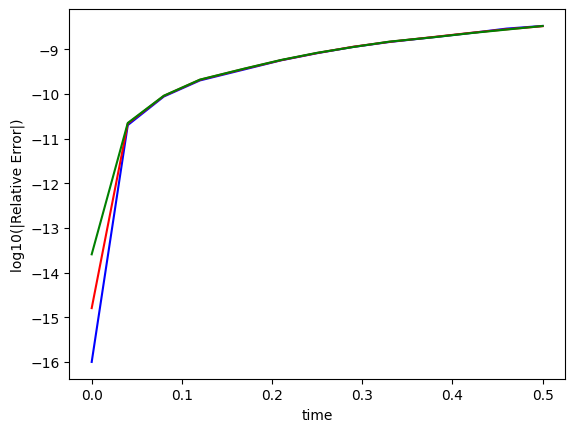

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

# from https://stackoverflow.com/questions/52386747/matplotlib-check-for-empty-plot
import numpy
time__arr = []
lgerr_arr = []
for i in [24, 48, 96]:
    t, log10error, num, exact = numpy.loadtxt(fname='output_resolution_'+str(i)+'cubed.txt', delimiter=' ', unpack=True)
    time__arr.append(t)
    lgerr_single_dataset = []
    if i != 24:
        print("Moving from 24^3 grid to "
              +str(i)+"^3 grid, logarithmic drop in numerical error should be "+'%.2f' % (4*np.log10(i/(24.0))))
    for log10err_onept in log10error:
        lgerr_single_dataset.append(log10err_onept + 4*np.log10(i/(24.0)))
    lgerr_arr.append(lgerr_single_dataset)

fig, ax = plt.subplots()
ax.set_xlabel('time')
ax.set_ylabel('log10(|Relative Error|)')
ax.plot(time__arr[0], lgerr_arr[0], color='b')
ax.plot(time__arr[1], lgerr_arr[1], color='r')
ax.plot(time__arr[2], lgerr_arr[2], color='g')

# Step 6: Exercises for students
### \[Back to [top](#toc)\]

1. Adjust the above code to make it run twice as fast on the same numerical grid while generating exactly the same results (stored in the files above). *Bonus*: Can you make it run any faster than twice as fast (while still being written in "pure" Python, using `NumPy`)?
1. How much should the (absolute value of the) relative error `|rel_error|` drop if we were to double the resolution, assuming instead 6th-order convergence? How will this adjust the `log10(|rel_error|)`?
1. Why did we add a nonzero constant offset to the exact solution? (*Hint: Start from the definition of relative error.*)
1. What will happen to the convergence order if we continue the simulation for a much longer time, say to $t=2$? Why? (*Hint: Convergence order will plummet!*)